In [1]:
import pandas as pd
import time, datetime, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle, utils

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [2]:
tini, tend = datetime.datetime(2024, 4, 30, 0, 0, 0), datetime.datetime(2024, 12, 31, 0, 0, 0)
data, data_err = utils.load_data(tini, tend)

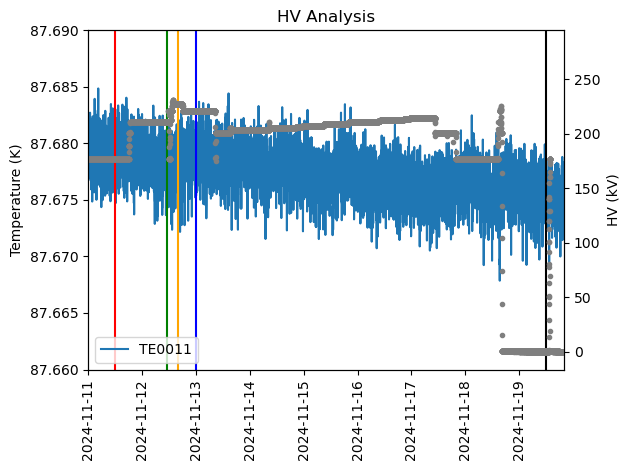

In [59]:
channel = "TE0011"
fig, axes = plt.subplots(1,1)
plt.xticks(rotation=90)
plt.title("HV Analysis")
plt.xlim(datetime.datetime(2024, 11, 11, 0, 0, 0), datetime.datetime(2024, 11, 19, 20, 0, 0))
axes2 = axes.twinx()

conditions = (data[channel]<90)&(data[channel]>86)

axes.plot(data.loc[conditions].index.to_numpy(), data.loc[conditions][channel].to_numpy(), label=fr"{channel}")
axes.axvline(datetime.datetime(2024, 11, 11, 12, 0, 0), color="red")
axes.axvline(datetime.datetime(2024, 11, 12, 16, 0, 0), color="orange")
axes.axvline(datetime.datetime(2024, 11, 12, 11, 0, 0), color="green")
axes.axvline(datetime.datetime(2024, 11, 13, 0, 0, 0), color="blue")
axes.axvline(datetime.datetime(2024, 11, 19, 12, 0, 0), color="black")
axes.legend(loc="lower left")
axes2.plot(data.index.to_numpy(), 1e-3*data["Heinz_VRaw"].to_numpy(), ".", color="tab:grey")
axes.set_ylabel("Temperature (K)")
axes.set_ylim(87.66, 87.69)
axes2.set_ylabel("HV (kV)")
fig.tight_layout()
fig.savefig(fr"/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Plots/HV_analysis/tevolution.png", format="png")
# data["TE0001"].loc[(data["TE0001"]<90)&(data["TE0001"]>87)].plot()
# data["Heinz_VRaw"].plot()

(20046.0, 20046.833333333332)

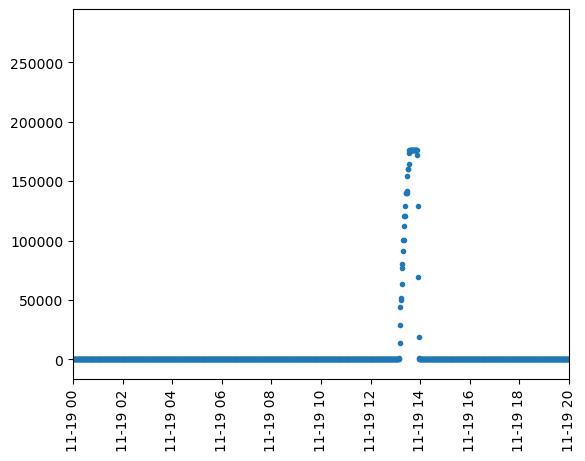

In [44]:
hv_0 = (data["Heinz_VRaw"]<1e7)
plt.plot(data.loc[hv_0].index.to_numpy(), data["Heinz_VRaw"].loc[hv_0].to_numpy(), ".")
plt.xticks(rotation=90);
plt.xlim(datetime.datetime(2024, 11, 11, 0, 0, 0), datetime.datetime(2024, 11, 19, 13, 0, 0))
#plt.plot(data["TE0032"].loc[hv_0].to_numpy(), data["Heinz_VRaw"].loc[hv_0].to_numpy(), ".")

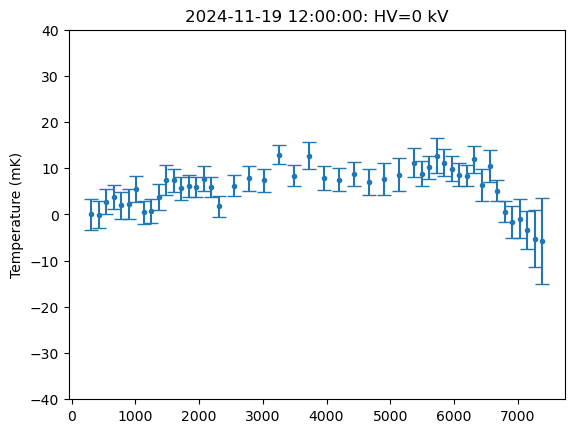

In [45]:
calib = utils.load_calib(
    path="/eos/user/j/jcapotor/RTDdata/calib/all/poff_2024-12-03 14:25:00.pkl"
    )["40525"]

date = datetime.datetime(2024, 11, 19, 12, 0, 0)
mapping = utils.load_mapping(date=date)

index = str(date)
row = data.loc[index]

tprofile, tprofile_err = {}, {}
fig, axes = plt.subplots(1,1)
for channel in row.index:
    mapping_row = mapping.loc[(mapping["SC-ID"]==channel)]
    system = mapping_row["SYSTEM"].values[0]
    if system != "TGRAD":
        continue
    try:
        sensor_id = str(int(mapping_row["CAL-ID"].iloc[0]))
    except:
        continue
    if sensor_id not in calib.index:
        continue
    tprofile[int(mapping_row["Y"].iloc[0])] = row[channel] - 1e-3*calib.loc[sensor_id]["cc"]
    tprofile_err[int(mapping_row["Y"].iloc[0])] = (data_err.loc[index][channel] + 1e-3*calib.loc[sensor_id]["cc_err"])
try:
    axes.errorbar(tprofile.keys(), 1e3*(np.array(list(tprofile.values())) - tprofile[305]), yerr=1e3*np.array(list(tprofile_err.values())), fmt=".", capsize=5)
    axes.set_title(fr"{index}: HV={1e-3*row['Heinz_VRaw']:.0f} kV")
    axes.set_ylim(-40, 40)
    axes.set_ylabel("Temperature (mK)")
    fig.savefig(fr"/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Plots/HV_analysis/{index}: HV={1e-3*row['Heinz_VRaw']:.0f} kV.pdf", format="pdf")
    #plt.close(fig)
except:
    print("Not possible")